one bad thing is that here Poisson loss looks better than MSE, while for 8K data MSE works more reliably. I would say just do all these hyperparmeter selection on 8K data, and don't show that loss type figure of CRCNS data.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished.builder import load_modules

# load_modules()

In [4]:
folder_to_check = 'scripts/training/crcns_pvc8_large'
path.insert(0, join(dir_dict['root'], folder_to_check))
from maskcnn_polished_explore_input.submit import param_iterator_obj
from maskcnn_polished_explore_input.key_utils import keygen

from maskcnn_polished.submit import param_iterator_obj as param_iterator_obj_old
from maskcnn_polished.key_utils import keygen as keygen_old

from itertools import chain

In [5]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(chain(param_iterator_obj.generate(), param_iterator_obj_old.generate())):
        if idx % 50 == 0:
            print(idx)
        
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 7
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
        if len(param) == 18:
#         assert param['split_seed'] == 'legacy'
        
        
        
            key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        elif len(param) == 16:
            key = keygen_old(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        else:
            raise RuntimeError
            
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
#         result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        _df_collect.append(
            {
                'split_seed': str(param['split_seed']),
                
                'setup': f"{param.get('px_kept', 144)}/{param.get('downscale_ratio', 4)}",
                
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'shuffle_type': param['shuffle_type'],
                'loss_type': param['loss_type'],
                
                # 5 to go
                
                'scale': eval(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 1 to go
                
                
                'model_seed': param['model_seed'],
                'corr_test': result['stats_best']['stats']['test']['corr_mean'],
#                 'max_epoch': max(num_epochs),
#                 'num_param': count_params(result['model']),
            }
        )
        _df =  pd.DataFrame(_df_collect, columns=['split_seed',
                                                  'setup',
                                                  'act_fn', 'bn_before_act', 'bn_after_fc',
                                                  'shuffle_type', 'loss_type', 'scale',
                                                  'smoothness',
                                                  'model_seed',
                                                  'corr_test',
#                                                   'num_param',
#                                                   'max_epoch',
                                                 ])
        _df = _df.set_index(['split_seed',
                             'setup',
                             'act_fn', 'bn_before_act', 'bn_after_fc',
                             'shuffle_type', 'loss_type', 'scale',
                             'smoothness',
                             'model_seed',
                            ],verify_integrity=True)['corr_test']
        _df = _df.unstack('model_seed').mean(axis=1).sort_index()
    return _df

In [6]:
# collect all data.
# it's a series.
df = load_everything()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400


In [7]:
# only focus on the split seed == 'legacy' part.

In [8]:
df

split_seed  setup  act_fn    bn_before_act  bn_after_fc  shuffle_type  loss_type  scale    smoothness
0           144/4  relu      False          False        legacy        mse        0.01105  0.00002       0.727516
                                                                       poisson    0.01105  0.00002       0.714077
                                                         paired        mse        0.01105  0.00002       0.680486
                                                                       poisson    0.01105  0.00002       0.678638
                                            True         legacy        mse        0.01105  0.00002       0.613049
                                                                       poisson    0.01105  0.00002       0.574182
                                                         paired        mse        0.01105  0.00002       0.550548
                                                                       poisson    0.01105  0.00002  

In [9]:
# df_to_use = df.xs('0', level='split_seed')
df_to_use = df

In [10]:
# also, remove bn_before_act, as this is not investigated in Plos paper; this actually makes my argument difficult,
# as bn_before_act=False is actually a little better. so just remove it
# df_to_use = df_to_use.xs(False, level='bn_before_act')

In [11]:
df_to_use

split_seed  setup  act_fn    bn_before_act  bn_after_fc  shuffle_type  loss_type  scale    smoothness
0           144/4  relu      False          False        legacy        mse        0.01105  0.00002       0.727516
                                                                       poisson    0.01105  0.00002       0.714077
                                                         paired        mse        0.01105  0.00002       0.680486
                                                                       poisson    0.01105  0.00002       0.678638
                                            True         legacy        mse        0.01105  0.00002       0.613049
                                                                       poisson    0.01105  0.00002       0.574182
                                                         paired        mse        0.01105  0.00002       0.550548
                                                                       poisson    0.01105  0.00002  

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

from thesis_v2.plots.basic import scatter
from thesis_v2.plots.util import savefig

In [13]:
def plot_scatter(df_this, key1, key2, level, xlabel, ylabel, key):
    plt.close('all')
    fig, ax = plt.subplots(figsize=(3,3))
    
    x = df_this.xs(key1, level=level).sort_index().values
    y = df_this.xs(key2, level=level).sort_index().values
    
    scatter(ax, x, y, xlabel, ylabel, xlim=(0.0, 0.8), ylim=(0.0,0.8))
    # TODO set tick labels.
    ax.text(0.05, 0.95, f'N={x.size}',
            horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes)
    
    # adjust figure size to make sure the aspect ratio is correct.
    fig.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.9)
    
    # save fig.
    savefig(fig, f'crcns_pvc8_large/maskcnn_polished/hyperparameter_no_size_change/{key}.pdf')
    
    plt.show()

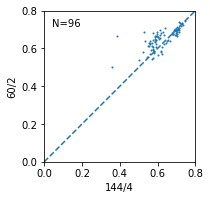

In [14]:
plot_scatter(df_to_use, '144/4', '60/2', 'setup', '144/4', '60/2', 'input_60d2_vs_144d4')
# os let's forget about the 50 one. just ignore that for now.

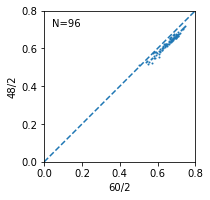

In [15]:
plot_scatter(df_to_use, '60/2', '48/2', 'setup', '60/2', '48/2', 'input_48d2_vs_60d2')

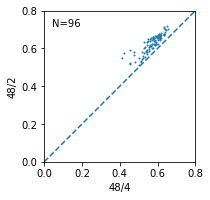

In [16]:
plot_scatter(df_to_use, '48/4', '48/2', 'setup', '48/4', '48/2', 'input_48d2_vs_48d4')

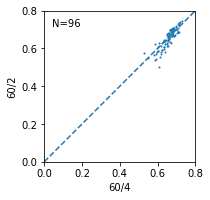

In [17]:
plot_scatter(df_to_use, '60/4', '60/2', 'setup', '60/4', '60/2', 'input_60d2_vs_60d4')

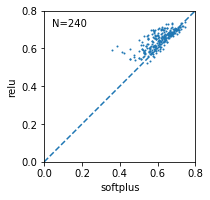

In [18]:
plot_scatter(df_to_use, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', 'act')

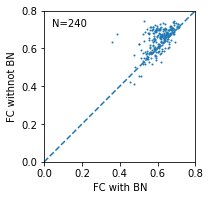

In [19]:
plot_scatter(df_to_use, True, False, 'bn_after_fc', 'FC with BN', 'FC withnot BN', 'bn_after_fc')

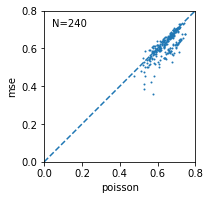

In [20]:
# loss_type
plot_scatter(df_to_use, 'poisson', 'mse', 'loss_type', 'poisson', 'mse', 'losstype')

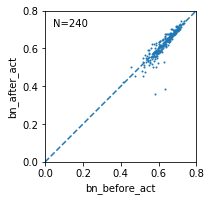

In [21]:
plot_scatter(df_to_use, True, False, 'bn_before_act', 'bn_before_act', 'bn_after_act', 'bn_before_act')